## Import Dependencies

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
import sqlite3 #for querying data 
from datetime import datetime


# Data Visualization Libraries:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Data Analysis: Statistics and Machine Learning Libraries
from scipy import stats
import scikit_posthocs as sp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Import Dataset
 - Data downloaded from https://data.lacity.org/resource/63jg-8b9z.json on 12/3/19

In [2]:
# import data using read_csv() method
df = pd.read_csv("/Users/trinitycisneros/Documents/Coding/bitterscientist.com/Crime_Data_from_2010_to_Present.csv")

## Filter Dataset

In [3]:
# This study will evaluate trends in weapon related crimes, and as such, will use the following features
weapon_crime_df = df[['Date Rptd', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Crm Cd 1', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'AREA NAME' , 'LAT', 'LON']]
# Renamed columns
weapon_crime_df.columns = ["Date_Reported", "Vict_Age", "Vict_Sex", "Vict_Desc", "Crime_Code", "Weapon_Code", "Weapon_Desc", "Status", "Area_Name", "Lat", "Lng"]

## Omit all records missing data

In [4]:
weapon_crime_df = weapon_crime_df.dropna(how='any', subset=['Weapon_Desc', 'Vict_Sex', 'Vict_Desc', 'Crime_Code', 'Status']).copy()

## Update Column Datatypes

In [5]:
# Create lists for categorical and int columns
cat_col = ['Vict_Sex', 'Vict_Desc', 'Weapon_Desc', 'Status', 'Area_Name']
int_col = ['Vict_Age', 'Weapon_Code', 'Crime_Code']
string_col = ['Date_Reported']

In [6]:
# Convert events column into int using a for loop
for col in int_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('int64')

In [7]:
# Convert events column into category using a for loop
for col in cat_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('category')

In [8]:
# Convert events column into category using a for loop
for col in string_col:
    weapon_crime_df[col] = weapon_crime_df[col].astype('str')

In [9]:
# Convert date_reported column into a datetime column
weapon_crime_df['Date_Reported'] =  pd.to_datetime(weapon_crime_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')

## Relabel categorical data

In [10]:
descent_dict = {'A' : 'Other Asian', 'B' : 'Black', 'C' : 'Chinese', 'D' : 'Cambodian', 'F' : 'Filipino', 'G' : 'Guamanian', 'H' : 'Hispanic/Latin/Mexican', 'I' : 'American Indian/Alaskan Native', 'J' : 'Japanese', 'K' : 'Korean', 'L' : 'Laotian', 'O' : 'Other', 'P' : 'Pacific Islander', 'S': 'Samoan', 'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown', 'Z':'Asian Indian'}

In [11]:
weapon_crime_df['Vict_Desc'].replace(descent_dict, inplace= True)

## Filter out 2019 values (as it is incomplete)

In [12]:
end_year = '2019-01-01'
mask = weapon_crime_df['Date_Reported'] < end_year
weapon_df = weapon_crime_df.loc[mask]

### Research Questions
### What are the top 10 crimes involving weapons
### What are the top 10 weapons reported in crimes
### What are general features of the all victims
### How have weapon related crimes changed over the reporting period
 - What are the victim profiles
 - What was the crime reported
### In the past year, where were these crimes committed?
### In the past year, are there regional differences in weapon usage accross the city?
### How does a regions annual household income affect weapon related crimes?

## What are the top 10 crimes involving weapons

In [13]:
# Get the top 10 crimes
wc_top_10 = weapon_df['Crime_Code'].value_counts()[0:9]

In [14]:
# To rename the crime codes with their crime description prepare a list of crimes
index_ = ['Battery - misdemeanor', 'Spousal/Cohab Abuse - Simple Assault', 'Assault with a Deadly Weapon', 'Robbery', 'Criminal Threats', 'Spousal beating', 'Brandishing', 'Robbery - attempted', 'Assault on Firefighter or Peace Officer With Deadly Weapon']

In [15]:
# Set the index 
wc_top_10.index = index_

In [16]:
# Prepare a dataframe
wc_top_10_df = pd.DataFrame(wc_top_10)

In [17]:
# Rename column
wc_top_10_df.columns=["Total Count"]
wc_top_10_df

,Total Count
Battery - misdemeanor,170812
Spousal/Cohab Abuse - Simple Assault,96159
Assault with a Deadly Weapon,81631
Robbery,75130
Criminal Threats,44077
Spousal beating,12419
Brandishing,12083
Robbery - attempted,10743
Assault on Firefighter or Peace Officer With Deadly Weapon,9857


## What are the top 10 weapons reported in crimes

In [18]:
# Get the top 10 crimes
weapon_top_10 = weapon_df['Weapon_Desc'].value_counts()[0:9]

In [19]:
# A list of the categories of the top ten weapons
top_10_weapons = list(weapon_top_10.index.values.tolist())

In [20]:
weapon_top_10_df = pd.DataFrame(weapon_top_10)
weapon_top_10_df.columns=["Total Count"]
weapon_top_10_df

,Total Count
"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",382711
VERBAL THREAT,52204
UNKNOWN WEAPON/OTHER WEAPON,50293
HAND GUN,30272
SEMI-AUTOMATIC PISTOL,11789
KNIFE WITH BLADE 6INCHES OR LESS,11339
OTHER KNIFE,8482
UNKNOWN FIREARM,7019
VEHICLE,6435


## How have the top 10 weapons reported in crimes changed over time

In [21]:
strong_arm = weapon_df.loc[weapon_df["Weapon_Desc"] == 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)']

In [22]:
strong_arm.set_index(strong_arm["Date_Reported"],inplace=True)

In [23]:
strong_arm_values = strong_arm['Weapon_Desc'].resample('Y').count().values
strong_arm_yrs = list(strong_arm['Weapon_Desc'].resample('Y').count().index.year.tolist())
sa_df = pd.DataFrame({'years' : strong_arm_yrs, 'totals': strong_arm_values})

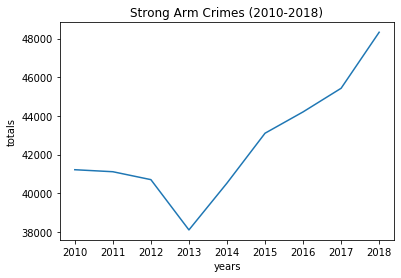

In [24]:
ax = sns.lineplot(x='years', y="totals", data=sa_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Strong Arm Crimes (2010-2018)')
plt.show()

In [25]:
verbal_threat = weapon_df.loc[weapon_df["Weapon_Desc"] == 'VERBAL THREAT']

In [26]:
verbal_threat.set_index(verbal_threat["Date_Reported"],inplace=True)

In [27]:
verbal_threat_values = verbal_threat['Weapon_Desc'].resample('Y').count().values
verbal_threat_years = list(verbal_threat['Weapon_Desc'].resample('Y').count().index.year.tolist())
vt_df = pd.DataFrame({'years' : verbal_threat_years, 'totals': verbal_threat_values})

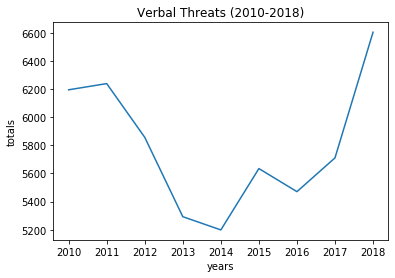

In [28]:
ax = sns.lineplot(x='years', y="totals", data=vt_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Verbal Threats (2010-2018)')
plt.show()

In [29]:
unknown_weapon = weapon_df.loc[weapon_df["Weapon_Desc"] == 'UNKNOWN WEAPON/OTHER WEAPON']

In [30]:
unknown_weapon.set_index(unknown_weapon["Date_Reported"],inplace=True)

In [31]:
unknown_weapon_values = unknown_weapon['Weapon_Desc'].resample('Y').count().values
unknown_weapon_years = list(unknown_weapon['Weapon_Desc'].resample('Y').count().index.year.tolist())
uw_df = pd.DataFrame({'years' : unknown_weapon_years, 'totals': unknown_weapon_values})

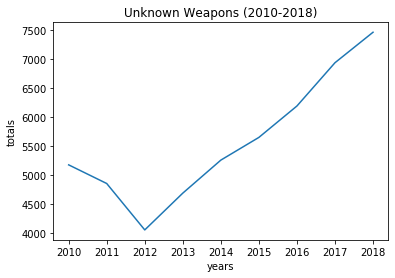

In [32]:
ax = sns.lineplot(x='years', y="totals", data=uw_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Unknown Weapons (2010-2018)')
plt.show()

In [33]:
handgun = weapon_df.loc[weapon_df["Weapon_Desc"] == 'HAND GUN']

In [34]:
handgun.set_index(handgun["Date_Reported"],inplace=True)

In [35]:
handgun_values = handgun['Weapon_Desc'].resample('Y').count().values
handgun_years = list(handgun['Weapon_Desc'].resample('Y').count().index.year.tolist())
h_df = pd.DataFrame({'years' : handgun_years, 'totals': handgun_values})

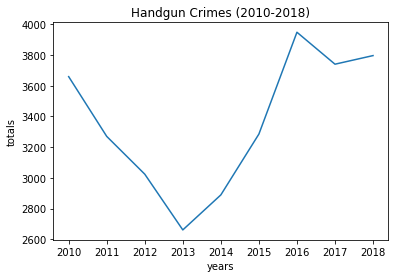

In [36]:
ax = sns.lineplot(x='years', y="totals", data=h_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Handgun Crimes (2010-2018)')
plt.show()

In [37]:
semi_auto = weapon_df.loc[weapon_df["Weapon_Desc"] == 'SEMI-AUTOMATIC PISTOL']

In [38]:
semi_auto.set_index(semi_auto["Date_Reported"],inplace=True)

In [39]:
sap_values = semi_auto['Weapon_Desc'].resample('Y').count().values
sap_years = list(semi_auto['Weapon_Desc'].resample('Y').count().index.year.tolist())
sap_df = pd.DataFrame({'years' : sap_years, 'totals': sap_values})

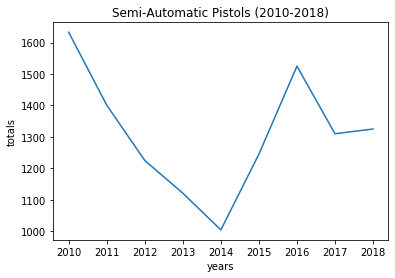

In [40]:
ax = sns.lineplot(x='years', y="totals", data=sap_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Semi-Automatic Pistols (2010-2018)')
plt.show()

In [41]:
knife_6_less = weapon_df.loc[weapon_df["Weapon_Desc"] == 'KNIFE WITH BLADE 6INCHES OR LESS']

In [42]:
knife_6_less.set_index(knife_6_less["Date_Reported"],inplace=True)

In [43]:
knife_values = knife_6_less['Weapon_Desc'].resample('Y').count().values
knife_years = list(knife_6_less['Weapon_Desc'].resample('Y').count().index.year.tolist())
knife_df = pd.DataFrame({'years' : knife_years, 'totals': knife_values})

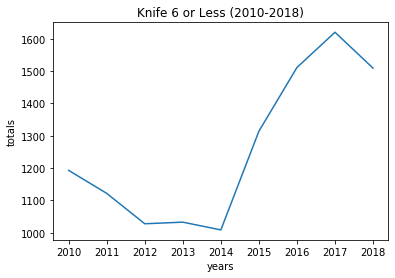

In [44]:
ax = sns.lineplot(x='years', y="totals", data=knife_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Knife 6 or Less (2010-2018)')
plt.show()

In [45]:
other_knife_less = weapon_df.loc[weapon_df["Weapon_Desc"] == 'OTHER KNIFE']

In [46]:
other_knife_less.set_index(other_knife_less["Date_Reported"],inplace=True)

In [47]:
otherknife_values = other_knife_less['Weapon_Desc'].resample('Y').count().values
otherknife_years = list(other_knife_less['Weapon_Desc'].resample('Y').count().index.year.tolist())
otherknife_df = pd.DataFrame({'years' : otherknife_years, 'totals': otherknife_values})

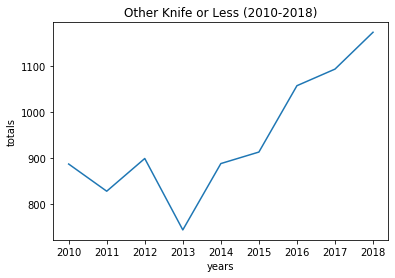

In [48]:
ax = sns.lineplot(x='years', y="totals", data=otherknife_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Other Knife or Less (2010-2018)')
plt.show()

In [49]:
unk_firearm = weapon_df.loc[weapon_df["Weapon_Desc"] == 'UNKNOWN FIREARM']

In [50]:
unk_firearm.set_index(unk_firearm["Date_Reported"],inplace=True)

In [51]:
unk_firearm_values = unk_firearm['Weapon_Desc'].resample('Y').count().values
unk_firearm_years = list(unk_firearm['Weapon_Desc'].resample('Y').count().index.year.tolist())
unk_firearm_df = pd.DataFrame({'years' : unk_firearm_years, 'totals': unk_firearm_values})

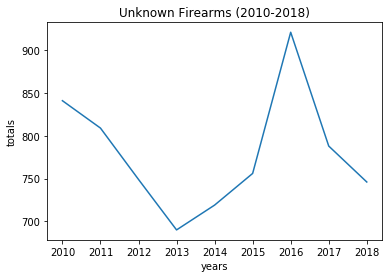

In [52]:
ax = sns.lineplot(x='years', y="totals", data=unk_firearm_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Unknown Firearms (2010-2018)')
plt.show()

In [53]:
vehicle = weapon_df.loc[weapon_df["Weapon_Desc"] == 'VEHICLE']

In [54]:
vehicle.set_index(vehicle["Date_Reported"],inplace=True)

In [55]:
vehicle_values = vehicle['Weapon_Desc'].resample('Y').count().values
vehicle_years = list(vehicle['Weapon_Desc'].resample('Y').count().index.year.tolist())
vehicle_df = pd.DataFrame({'years' : vehicle_years, 'totals': vehicle_values})

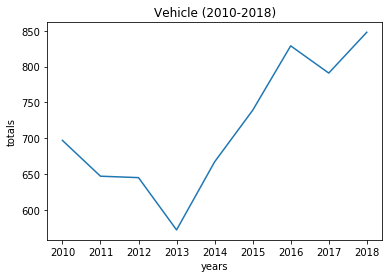

In [56]:
ax = sns.lineplot(x='years', y="totals", data=vehicle_df)
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.title('Vehicle (2010-2018)')
plt.show()

In [57]:
grouped = weapon_df.groupby('Weapon_Desc').resample('Y', on = "Date_Reported").count()
grouped_df = grouped[['Crime_Code']]
test_df = grouped_df.reset_index()
test_df['Date_Reported'] = test_df['Date_Reported'].dt.year
test_df.rename(columns={'Weapon_Desc': 'Weapon','Date_Reported':'Year', 'Crime_Code': 'Annual_Total'}, inplace=True)
test_df.head()

,Weapon,Year,Annual_Total
0,AIR PISTOL/REVOLVER/RIFLE/BB GUN,2010,223
1,AIR PISTOL/REVOLVER/RIFLE/BB GUN,2011,182
2,AIR PISTOL/REVOLVER/RIFLE/BB GUN,2012,157
3,AIR PISTOL/REVOLVER/RIFLE/BB GUN,2013,156
4,AIR PISTOL/REVOLVER/RIFLE/BB GUN,2014,181


In [61]:
top_crimes_data = test_df.groupby('Weapon')['Annual_Total'].mean().sort_values(ascending=False)[0:10]

In [62]:
# Convert top_10_weapons list into an array
array = np.asarray(top_10_weapons)

In [64]:
# Create a dataframe that only contains the top 10 weapons
frames = []
for value in array:
    temp_df = test_df.loc[test_df["Weapon"] == value]
    frames.append(temp_df)

In [65]:
top10weapon_df = pd.concat(frames, axis=0)
top10weapon_df = top10weapon_df.astype({'Weapon': 'str'})

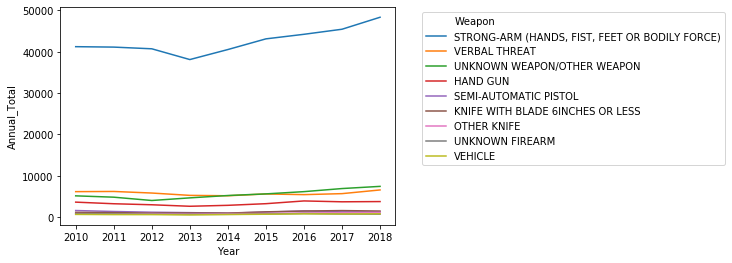

In [66]:
sns.lineplot(x="Year", y="Annual_Total", hue="Weapon", data=top10weapon_df)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1), ncol=1)
plt.show()

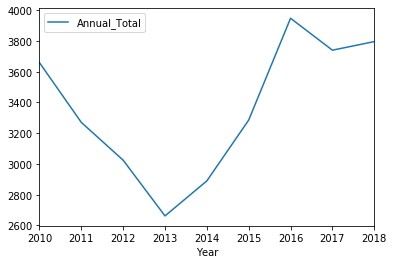

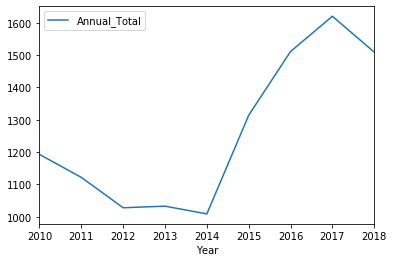

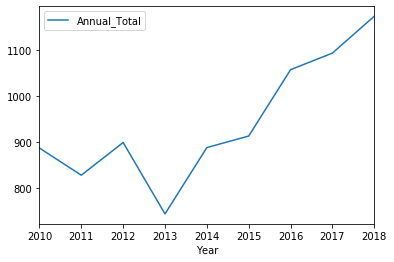

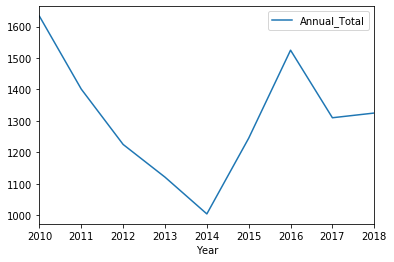

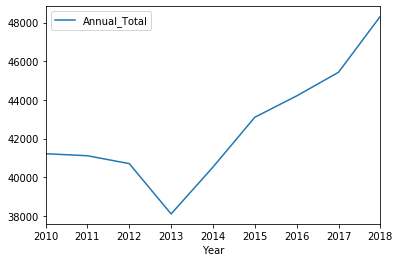

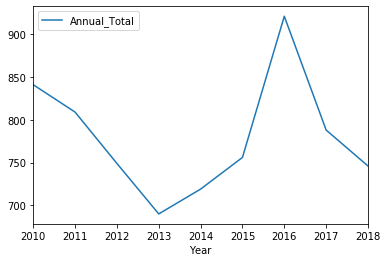

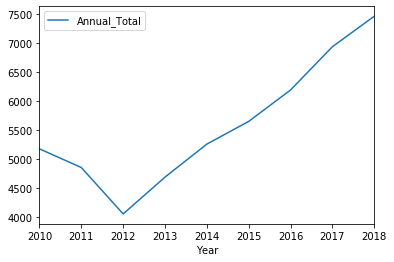

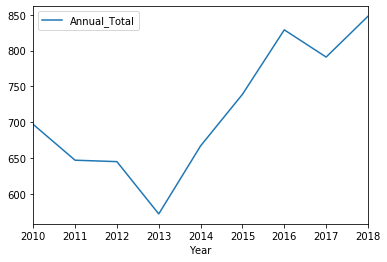

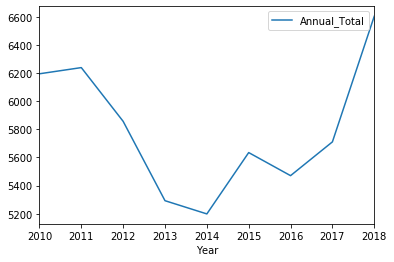

In [67]:
top10weapon_df.groupby('Weapon').plot(kind='line', x='Year', y='Annual_Total')
plt.show()

In [ ]:
# Sample code for preparing a grid of plots
# import matplotlib.pyplot as plt

grouped = df.groupby('dept')

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(x='date', y='residual', ax=ax)

ax.legend()
plt.show()

## What are general features of the all victims
 - Age
 - Sex
 - Age by Sex

In [ ]:
# Descriptive statistics for victim age for all sexes
weapon_crime_df[['Vict_Age']].describe()

In [ ]:
# Find out what is the age descriptive statistics by sex
vict_age_by_sex = weapon_crime_df.groupby('Vict_Sex')['Vict_Age'].describe()
# Drop non M or F categories
vic_age_by_sex = vict_age_by_sex.drop(['H', 'N', 'X'])
vic_age_by_sex

## Visualize distribution of the ages of victims in weapon related crimes

In [ ]:
# Plot all the victim age for all victims
sns.distplot(weapon_crime_df[['Vict_Age']], bins=10, kde=False).set_title('Ages of Crime Victims \n in LA County (2010 - Present)')
plt.savefig("static/images/vict_age_all_histogram.png", bbox_inches='tight')
plt.show()

## Visualize distribution of the ages of victims of weapon related crimes filtered for either Female or Male.

In [ ]:
# Subset data by victim sex for only known sexes
all_F_age_data = weapon_crime_df.loc[weapon_crime_df["Vict_Sex"] == "F"][['Vict_Age']]
# array with the female data
female_data = all_F_age_data['Vict_Age'].values
all_M_age_data = weapon_crime_df.loc[weapon_crime_df["Vict_Sex"] == "M"][['Vict_Age']]
# array with the male data
male_data = all_F_age_data['Vict_Age'].values

In [ ]:
# Plot all the victim age for all victims
fig1, axs1 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
sns.distplot(all_F_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[0]).set_title('Ages of Female Crime Victims \n in LA County (2010 - Present)')
sns.distplot(all_M_age_data, bins=10, kde=False, color='tab:blue', ax=axs1[1]).set_title('Ages of Male Crime Victims \n in LA County (2010 - Present)')
fig1.savefig("static/images/vict_age_by_sex_histograms.png", bbox_inches='tight')
plt.show()

## Determine if there is a difference in the mean number of crimes between male and female

### Test for normality and equal variance
 - cannot use a shapiro-wilk test because the p value will not be accurate with N > 5000

In [ ]:
import scipy.stats as stats
left = -1.8
fig = plt.figure(figsize=(8,8))

# qq plot for female victims
ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(female_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
# txt = ax.text(left, top, 'Ages of Female Victims', verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))
ax.title.set_text('Ages of Female Victims QQ Plot')

# qq plot for male victims
ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(male_data, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
# txt = ax.text(left, top, "Ages of Male Victims", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))
ax.title.set_text("Ages of Male Victims QQ Plot")

fig.tight_layout()
fig.savefig("static/images/vict_age_by_sex_qq_plots.png", bbox_inches='tight')
plt.show()

In [ ]:
# Test for equal variance
# scipy.stats.bartlett because I know the samples are normally distributed
barlette_result = stats.bartlett(female_data, male_data)
if barlette_result[1] >= 0.05:
    print("Do not reject the null hypothesis, all the input samples are from populations with equal variances.")
else:
    print("Reject the null hypothesis, the samples do not have equal variance")

### t-test for two indepedent samples

In [ ]:
vict_sex_t_test = stats.ttest_ind(female_data,male_data)
if vict_sex_t_test[1] >= 0.05:
    print(f"The p values is {vict_sex_t_test[1]}. Do not reject the null hypothesis.")
else:
    print(f"The p values is {vict_sex_t_test[1]}. Reject the null hypothesis, the samples significantly different.")

## <font color='red'>No significant difference in the mean age of victims by sex.</font>

## Explore the ethnic/racial makeup of victims of weapon related crimes

In [ ]:
# Get the top 10 victims of weapon related crimes by their descendant category
top10_vict_desc = weapon_crime_df['Vict_Desc'].value_counts()[0:10]
top10_vict_desc_df = pd.DataFrame(top10_vict_desc)
top10_vict_desc_df.columns=["Total_Count"]
top10_vict_desc_df

In [ ]:
# Make a list of the top 10 victim descent
# This will be the axist category for the bar plot
desc_cat = list(top10_vict_desc_df.index.values.tolist()) 

In [ ]:
# Prepare a list of the number of victims per descent category (in descending order)
# This will be the height value for the bar plot
vic_desc_values = top10_vict_desc.values.tolist()

In [ ]:
# plt.rcdefaults()
fig, ax = plt.subplots()
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=10)

# Example data
y = desc_cat
y_pos = np.arange(len(x))

ax.barh(y_pos, vic_desc_values, align='center', color='blue', alpha = 0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total Count')
ax.set_title("Total Victims in Weapons /n Related Crimes (2010 - 2019)")
plt.savefig("static/images/all_crimes_by_vict_desc.png", bbox_inches='tight') 

plt.show()

## <Font color='red'>The majority of victims of weapon related crimes are Hispanic, Black, and White individuals</Font>

## How have weapon related crimes changed over the reporting period
 - What are the victim profiles
 - What was the crime reported

## In the past year, where were these crimes committed?

## In the past year, are there regional differences in weapon usage accross the city?

## How does a regions annual household income affect weapon related crimes?